In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier

from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report

## 1. Загрузка данных

In [69]:
heart_df = pd.read_csv('./Data/heart.csv')
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## 2. Визуализация

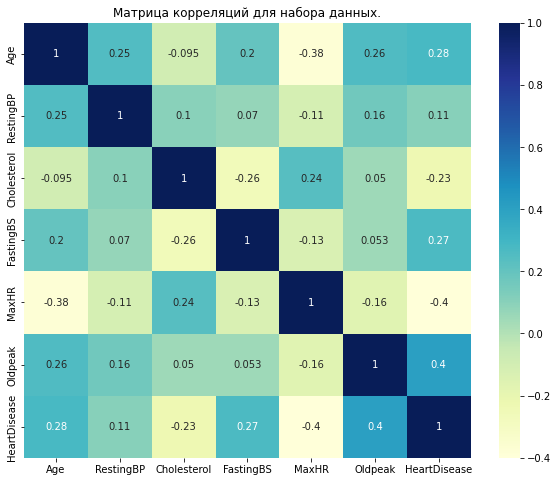

In [70]:
plt.figure(figsize=(10, 8))
sns.heatmap(heart_df.corr(), cmap="YlGnBu", annot=True)
plt.title('Матрица корреляций для набора данных.')
plt.show()

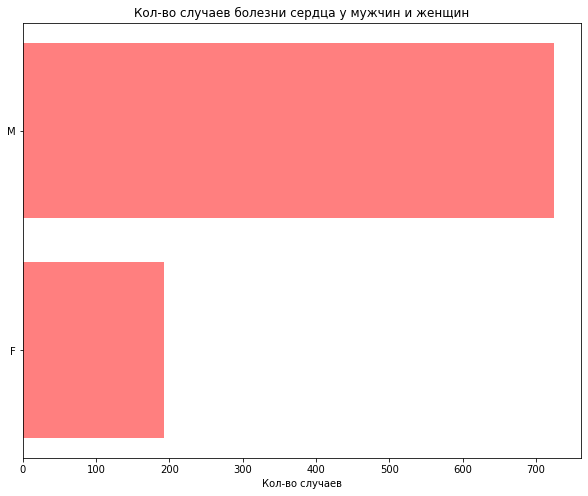

In [71]:
groupby_age = heart_df.groupby('Sex').agg({'HeartDisease': 'count'}).reset_index()

plt.figure(figsize=(10, 8))
plt.barh(
    groupby_age['Sex'],
    groupby_age['HeartDisease'],
    color='red', 
    alpha=0.5
)

plt.title('Кол-во случаев болезни сердца у мужчин и женщин')
plt.xlabel('Кол-во случаев')
plt.show()

## 3. Кодирование переменных

In [72]:
heart_df['Sex'] = LabelEncoder().fit_transform(heart_df['Sex'])

In [73]:
heart_df = pd.concat([heart_df, pd.get_dummies(heart_df['ChestPainType'])], axis=1)
heart_df.drop('ChestPainType', axis=1, inplace=True)

In [74]:
heart_df = pd.concat([heart_df, pd.get_dummies(heart_df['RestingECG'])], axis=1)
heart_df.drop('RestingECG', axis=1, inplace=True)

In [75]:
heart_df['ExerciseAngina'] = LabelEncoder().fit_transform(heart_df['ExerciseAngina'])

In [76]:
heart_df = pd.concat([heart_df, pd.get_dummies(heart_df['ST_Slope'])], axis=1)
heart_df.drop('ST_Slope', axis=1, inplace=True)

In [77]:
heart_df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ASY,ATA,NAP,TA,LVH,Normal,ST,Down,Flat,Up
0,40,1,140,289,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,0,160,180,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,0,138,214,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1


## 4. Разделение выборки на train и test

In [78]:
X = heart_df.drop('HeartDisease', axis=1)
y = heart_df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## 5. Обучение дерева решений и случайного леса

In [80]:
tree_decision = DecisionTreeClassifier().fit(X_train, y_train)
random_forest_model = RandomForestClassifier().fit(X_train, y_train)

y_pred_tree = tree_decision.predict(X_test)
y_pred_random_forest = random_forest_model.predict(X_test)

y_true = y_test

### 5.1 Оценка модели дерева решений

In [135]:
clf_report_tree = classification_report(y_true, y_pred_tree)
print(classification_report(y_true, y_pred_tree))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78        77
           1       0.87      0.78      0.82       107

    accuracy                           0.80       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.80      0.81       184



### 5.3 Оценка модели случайного леса

In [136]:
clf_report_random_forest = classification_report(y_true, y_pred_random_forest)
print(classification_report(y_true, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



## 6. Важность признаков модели случайный лес

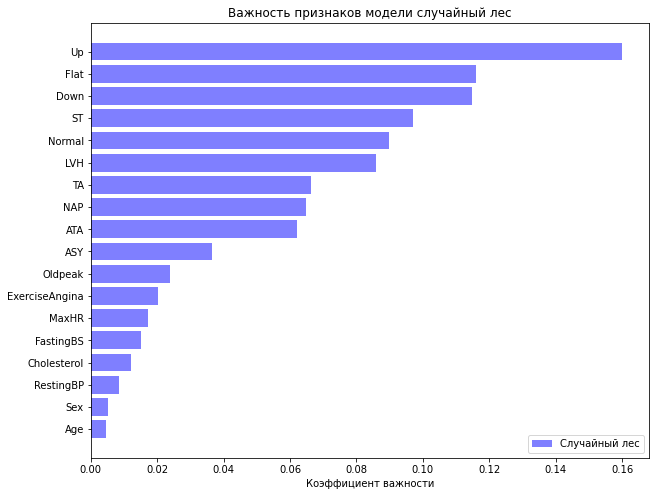

In [111]:
plt.figure(figsize=(10, 8))
plt.barh(
    X_train.columns,
    np.sort(random_forest_model.feature_importances_),
    alpha=0.5,
    color='blue'
)

plt.title('Важность признаков модели случайный лес')
plt.xlabel('Коэффициент важности')
plt.legend(['Cлучайный лес'])
plt.show()

## 7. Бэггинг над деревьями

In [114]:
bagging_on_tree = BaggingClassifier(DecisionTreeClassifier()).fit(X_train, y_train)

In [116]:
y_pred_bagging = bagging_on_tree.predict(X_test)

In [137]:
clf_report_bagging_on_tree = classification_report(y_pred_bagging, y_true)
print(classification_report(y_pred_bagging, y_true))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81        93
           1       0.78      0.91      0.84        91

    accuracy                           0.83       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.83      0.82       184



## 8. Stacking-clf (Дерево решений, случайный лес, метод опорных векторов)

In [128]:
estimators = [
    ('RandomForest', RandomForestClassifier()),
    ('DecisionTree', DecisionTreeClassifier())
]

stack_clf = StackingClassifier(estimators, final_estimator=LinearSVC()).fit(X_train, y_train)

In [129]:
y_pred_stack = stack_clf.predict(X_test)

In [138]:
clf_report_stack_model = classification_report(y_pred_stack, y_true)
print(classification_report(y_pred_stack, y_true))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        80
           1       0.89      0.91      0.90       104

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



## Выводы

После полученных результатов можно сказать, что всего себя показала модель Stacking(у нее самая большая f1 score метрика)

In [151]:
print('Результаты модели дерева решений\n')
print(clf_report_tree)
print('_______________________________________________________')
print('Результаты модели случайного леса\n')
print(clf_report_random_forest)
print('_______________________________________________________')
print('Результаты модели бэггинга над деревьями\n')
print(clf_report_bagging_on_tree)
print('_______________________________________________________')
print('Результаты модели стэккинга (дерево решений, случайный лес, метод опорных векторов)\n')
print(clf_report_stack_model)

Результаты модели дерева решений

              precision    recall  f1-score   support

           0       0.73      0.84      0.78        77
           1       0.87      0.78      0.82       107

    accuracy                           0.80       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.80      0.81       184

_______________________________________________________
Результаты модели случайного леса

              precision    recall  f1-score   support

           0       0.84      0.86      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

_______________________________________________________
Результаты модели бэггинга над деревьями

              precision    recall  f1-score   support

           0       0.90      0.74      0.81        93
           1  